## Задачі та етапи / Tasks and Stages

| № | Задача (UA)                           | Task (EN)                                         | Етап (UA) / Stage (EN)                                                     | Кінцева ціль (UA) / Goal (EN)                                              |
|---|---------------------------------------|---------------------------------------------------|---------------------------------------------------------------------------|----------------------------------------------------------------------------|
| 1 | Підготовка середовища                 | Environment setup                                 | Встановлення та імпорт бібліотек (TensorFlow, Keras, etc.) / Library import | Можливість швидко прототипувати моделі / Fast prototyping in Keras         |
| 2 | Завантаження датасету                 | Dataset loading                                   | Імпорт зображень і міток; базове EDA / Import images & labels, basic EDA   | Дані завантажені та досліджені / Data loaded and explored                  |
| 3 | Попередня обробка зображень           | Image preprocessing                               | Зміна розміру, нормалізація, аугментація / Resize, normalization, augment  | Зображення готові до тренування / Images ready for training                |
| 4 | Побудова CNN-архітектури              | Build CNN architecture                            | Визначення шарів (Conv → Pool → Dense → Output) / Define layers            | Описана та закодована архітектура / Model architecture defined & coded     |
| 5 | Налаштування гіперпараметрів          | Hyperparameter tuning                             | Оптимізатор, learning rate, batch size, epochs / Optimizer, lr, batch, ep. | Визначено робочі гіперпараметри / Working hyperparameters set              |
| 6 | Тренування моделі                     | Model training                                    | Запуск тренувального циклу; моніторинг метрик / Training loop, metrics     | Отримані ваги моделі / Model weights minimizing train loss                 |
| 7 | Оцінка якості                         | Model evaluation                                  | Валідація на тестовому наборі; метрики / Test set validation, metrics      | Виміряні показники якості / Quality metrics measured                       |
| 8 | Розгортання логіки прийняття рішення  | Deploy decision logic                             | Реалізація функції `predict_and_open(…)` / Implement `predict_and_open()`  | Відкриття дверей лише для “happy” / Door opens only for "happy"            |
| 9 | Домашнє завдання                      | Homework: end-to-end solution                     | Реалізація end‑to‑end рішення за власною логікою / Custom end-to-end impl. | Самостійно побудувати та протестувати модель / Build & test your own model |

---  
| Загальна кінцева ціль (UA) / Overall Goal (EN) | Опис (UA) / Description (EN)                                                                                                                                                                                                                           |
|-----------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **End‑to‑end система перевірки «щастя» / End-to-end "happiness" verification system** | Побудувати, натренувати та протестувати CNN‑модель на Keras, яка на вхід отримує зображення з камери дверей, а на вихід дає бінарний прогноз (`happy`/`not_happy`) і реалізує функцію автоматичного відкриття дверей тільки при позитивному результаті. / Build, train, and test a Keras CNN model that takes a door camera image as input and outputs a binary prediction (`happy`/`not_happy`), automatically opening the door only for a positive result. |


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D # type: ignore
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D # type: ignore
from keras.models import Model # type: ignore

from IPython.display import Image, display
plt.style.use('seaborn-v0_8-darkgrid')


2025-07-13 14:29:53.406757: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## **Завантаження даних / Loading data**

In [2]:
train_path = '/Users/vladislavpleshko/Documents/VS Code/before/amazinum/data/train.h5'
test_path = '/Users/vladislavpleshko/Documents/VS Code/before/amazinum/data/test.h5'


In [3]:
def load_dataset(train_path, test_path):
    train_dataset = h5py.File(train_path, "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File(test_path, "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


## **Підготовка даних / Preparing data**

In [4]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset(train_path, test_path)

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))


number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


In [5]:
INPUT_SHAPE = X_train[1].shape
print(INPUT_SHAPE)
print(classes)


(64, 64, 3)
[0 1]


In [6]:
Y_test.T


array([[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0]])

In [7]:
import inspect
def inspect_layer(layer):
    """
    Виводить конфігурацію шару layer.get_config() у вигляді зручної таблички.
    """
    config = layer.get_config()
    max_key_len = max(len(str(k)) for k in config.keys())

    print(f"Layer: {layer.__class__.__name__}")
    # Додатково — показати сигнатуру конструктора
    try:
        sig = inspect.signature(layer.__class__)
        print(f"Constructor signature: {sig}")
    except (ValueError, TypeError):
        pass
    print("-" * (max_key_len + 5))

    for key, val in config.items():
        # Вирівнюємо ключі ліворуч по max_key_len
        print(f"{key.ljust(max_key_len)} : {val}")
    print("-" * (max_key_len + 5))


In [8]:
layer = ZeroPadding2D()

inspect_layer(layer)


Layer: ZeroPadding2D
Constructor signature: (padding=(1, 1), data_format=None, **kwargs)
----------------
name        : zero_padding2d
trainable   : True
dtype       : {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}
padding     : ((1, 1), (1, 1))
data_format : channels_last
----------------


## **Побудова моделі нейронної мережі / Creating a neural network model**

In [9]:
def HappyModel(input_shape=INPUT_SHAPE):
    X_input = Input(shape=(input_shape), name='Input_image')

    # first layer
    X = ZeroPadding2D(padding=3, name='zero_padding2d')(X_input)
    X = Conv2D(filters=32, kernel_size=(7,7), strides=(1,1), padding='valid', name='conv1')(X)

    X = BatchNormalization(axis=-1, name='bn0')(X)
    X = Activation('relu', name='activation')(X)

    X = MaxPooling2D(pool_size=(2,2), name='max_pool2d')(X)

    X = Flatten(name='Flatten')(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)


    model = Model(inputs=X_input, outputs=X, name='HappyModel')

    return model

model = HappyModel()
model.summary()


Model: "HappyModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_image (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 70, 70, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 64, 64, 32)     │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 64, 64, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool2d (MaxPooling2D)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │        32,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,633 (147.00 KB)

 Trainable params: 37,569 (146.75 KB)

 Non-trainable params: 64 (256.00 B)

Модель вирішує задачу: Класифікації зображення (розміром 64×64×3) на щасливе / нещасливе обличчя.
На виході — ймовірність (sigmoid), що особа щаслива.

In [10]:
from keras.callbacks import EarlyStopping # type: ignore
early_stop = EarlyStopping(
    monitor='val_loss',        # Що відстежувати (наприклад, 'val_loss', 'val_accuracy')
    patience=5,                # Скільки епох чекати без покращення, перш ніж зупинити тренування
    min_delta=0.0,             # Мінімальна зміна, яку вважаємо покращенням (ігнорує дрібні коливання)
    mode='auto',               # 'min', 'max' або 'auto' — як інтерпретувати покращення (мінімізація чи максимізація)
    restore_best_weights=False,# Якщо True — після зупинки повертає ваги з найкращої епохи
    verbose=1,                 # 1 — виводити повідомлення про зупинку, 0 — тихо
    baseline=None,             # Якщо задано — тренування зупиниться, якщо метрика не покращиться відносно цього значення
    start_from_epoch=0         # З якої епохи почати відстеження (можна пропустити початковий "розгін")
)


In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


### Блок перевірки даних для тренування 
*p.s знаю, що фактично це було виконано у комірці після завантаження даних, але хочу закріпити та практикувати це для себе*

In [12]:
# перевірка даних для тренування
print(X_train.dtype)
print(X_train.min(), X_train.max())
print(X_test.min(), X_test.max())


float64
0.00392156862745098 1.0
0.011764705882352941 1.0


In [13]:
print('Y_train dtype:', Y_train.dtype)
print('Y_train shape:', Y_train.shape)
print('Unique labels:', np.unique(Y_train))


Y_train dtype: int64
Y_train shape: (600, 1)
Unique labels: [0 1]


In [14]:
# баланс класів
unique, counts = np.unique(Y_train, return_counts=True)
class_distribution = dict(zip(unique.flatten(), counts))

print("Class distribution in Y_train:", class_distribution)


Class distribution in Y_train: {0: 300, 1: 300}


In [15]:
# узгодженість кількості прикладів X/Y
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("Match:", X_train.shape[0] == Y_train.shape[0])


X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
Match: True


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train,
                                                  test_size=0.15,
                                                  stratify=Y_train)

for arr, name in zip([X_train, X_test, X_val, Y_train, Y_test, Y_val], ['X_train', 'X_test', 'X_val', 'Y_train', 'Y_test','Y_val']):
    print(f'{name}:{arr.shape}')


X_train:(510, 64, 64, 3)
X_test:(150, 64, 64, 3)
X_val:(90, 64, 64, 3)
Y_train:(510, 1)
Y_test:(150, 1)
Y_val:(90, 1)


In [17]:
history = model.fit(X_train, Y_train,
                    batch_size=32,
                    verbose=1,
                    epochs=50,
                    validation_data=[X_val, Y_val],
                    callbacks=[early_stop] )


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.5280 - loss: 3.4537 - val_accuracy: 0.5222 - val_loss: 0.6330
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.7676 - loss: 0.5332 - val_accuracy: 0.5111 - val_loss: 0.6499
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9373 - loss: 0.1601 - val_accuracy: 0.6333 - val_loss: 0.5398
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9450 - loss: 0.1427 - val_accuracy: 0.5889 - val_loss: 0.6569
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9577 - loss: 0.1247 - val_accuracy: 0.6889 - val_loss: 0.5014
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.9754 - loss: 0.1138 - val_accuracy: 0.7444 - val_loss: 0.4465
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.9919 - loss: 0.0846 - val_accuracy: 0.7556 - val_loss: 0.4141
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9762 - loss: 0.0788 - val_accuracy: 0.

## **Оцінка якості моделі / Evaluate model**

In [18]:
test_results = model.evaluate(X_test, Y_test, verbose=0)
print(f'Test loss: {test_results[0]:.4f}, Test accuracy: {test_results[1]:.2f}')


Test loss: 0.1912, Test accuracy: 0.95


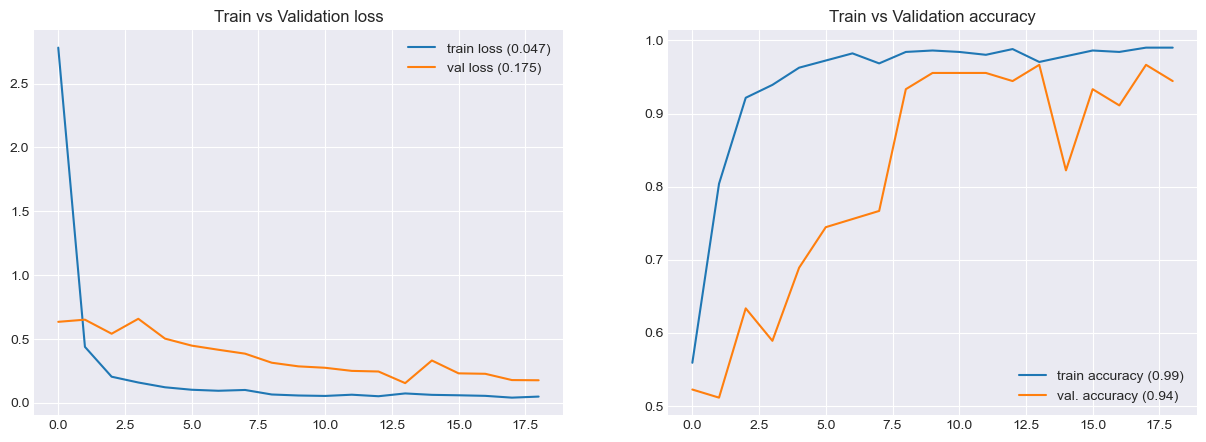

In [19]:
history_data = history.history

def plot_training_history(history_data):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history_data['loss'], label=f"train loss ({round(history_data['loss'][-1],3)})")
    plt.plot(history_data['val_loss'], label=f"val loss ({round(history_data['val_loss'][-1],3)})")
    plt.title('Train vs Validation loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history_data['accuracy'], label=f"train accuracy ({round(history_data['accuracy'][-1],2)})")
    plt.plot(history_data['val_accuracy'], label=f"val. accuracy ({round(history_data['val_accuracy'][-1],2)})")
    plt.legend()
    plt.title('Train vs Validation accuracy')

    plt.show()

plot_training_history(history_data)


In [20]:
probs = model.predict(X_test)
probs = probs.flatten()
probs


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


array([0.9986376 , 0.93481964, 0.9947121 , 0.99989444, 0.7581971 ,
       0.94798535, 0.9414681 , 0.2633242 , 0.99901026, 0.16477555,
       0.8956544 , 0.34854987, 0.90023017, 0.42862183, 0.21617788,
       0.9609158 , 0.03037067, 0.945862  , 0.0249601 , 0.9997751 ,
       0.99638367, 0.9911144 , 0.42697072, 0.9989641 , 0.0251306 ,
       0.06104246, 0.9178196 , 0.16054471, 0.6673934 , 0.99326944,
       0.99629587, 0.9987869 , 0.9517774 , 0.99991494, 0.99979293,
       0.99969333, 0.16552852, 0.15498917, 0.658787  , 0.0927183 ,
       0.8444463 , 0.32943314, 0.20292084, 0.21113801, 0.9998253 ,
       0.08110467, 0.04188031, 0.11989437, 0.982082  , 0.14097635,
       0.12834173, 0.16703072, 0.91119474, 0.8979165 , 0.23870768,
       0.9824575 , 0.9488475 , 0.8845612 , 0.9815148 , 0.99893737,
       0.6411251 , 0.9657945 , 0.58333   , 0.85934013, 0.9947755 ,
       0.6732439 , 0.8849546 , 0.907314  , 0.99781066, 0.9980385 ,
       0.98887694, 0.30006552, 0.5796061 , 0.24808058, 0.34229

In [21]:
threshold = 0.5
preds = (probs > threshold).astype(int)
preds


array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0])

In [22]:
num_samples = 9
idxs = np.random.choice(len(X_test),num_samples,replace=False)
idxs


array([110,  83,  30,  33,  70, 132,  92, 103,  80])

### **Виведення результатів / Output of results**

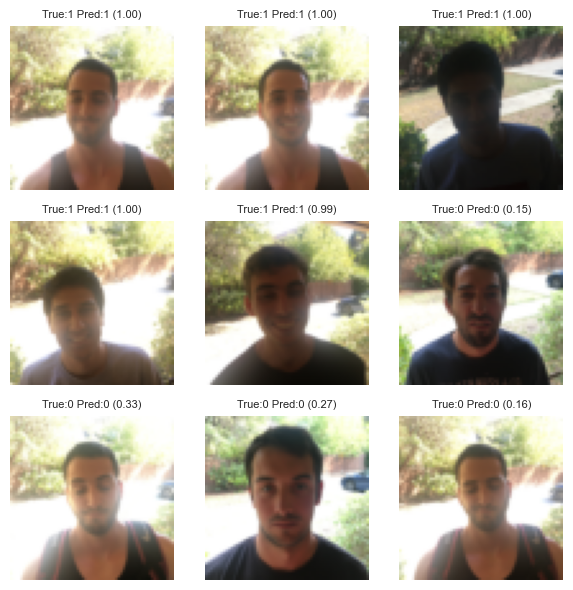

In [23]:
side = int(np.sqrt(num_samples))
plt.figure(figsize=(side*2, side*2))

for i, idx in enumerate(idxs):
    plt.subplot(side, side, i+1)
    plt.imshow(X_test[idx])
    plt.axis('off')
    true = int(Y_test[idx].flatten()[0])
    plt.title(f"True:{true} Pred:{preds[idx]} ({probs[idx]:.2f})", fontsize=8)
plt.tight_layout()
plt.show()


In [24]:
def predict_and_open(image, model, threshold=0.5):
    """
    Приймає зображення (масив numpy, shape=(64,64,3)), модель і поріг.
    Повертає True, якщо "happy" (двері відкриваються), інакше False.
    """
    # Перевірка на нормалізоване фото
    if image.max() > 1.0:
        img_norm = image / 255.
    else:
        img_norm = image

    img_input = np.expand_dims(img_norm, axis=0)
    prob = model.predict(img_input)[0, 0]
    is_happy = prob > threshold

    # Виведення зображення
    plt.imshow(img_norm)
    plt.axis('off')
    plt.title(f"Probability: {prob:.2f} {'(happy)' if is_happy else '(not happy)'}")
    plt.show()

    if is_happy:
        print("Door opened! (happy face detected)")
    else:
        print("Access denied. (not happy)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


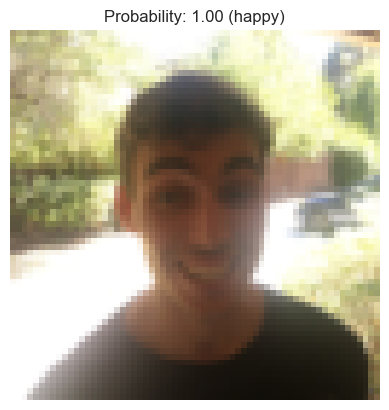

Door opened! (happy face detected)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


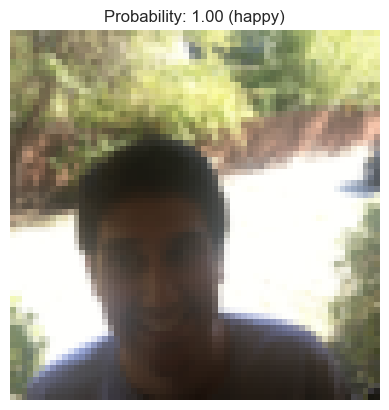

Door opened! (happy face detected)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


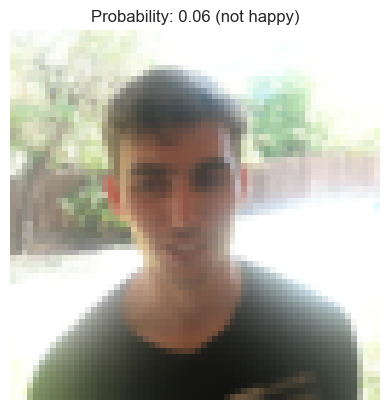

Access denied. (not happy)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


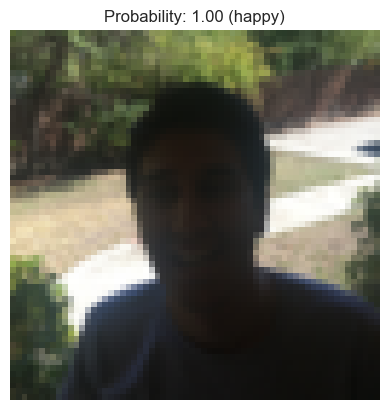

Door opened! (happy face detected)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


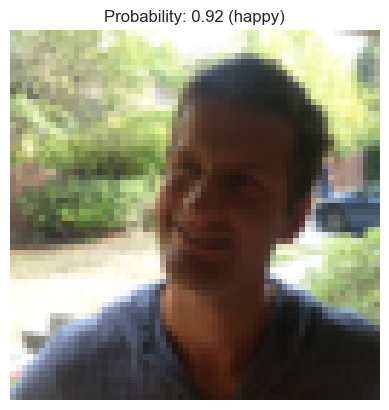

Door opened! (happy face detected)


In [25]:
# Візьмемо перше зображення з валідаційної вибірки для прикладу

for photo in range(5):
    predict_and_open(X_val[photo], model, threshold=0.5)


## Експериментальний блок / Experimental block

| Версія  | Зміна                                            | Коментар                                   |
| ------- | ------------------------------------------------ | ------------------------------------------ |
| `v1.0`  | Базова CNN, 1 Conv-блок                          | Вихідна точка                              |
| `v1.1`  | +1 Conv-блок                                     | Глибша CNN                                 |
| `v1.2`  | +2 Conv-блок                                     | Ще глибше                                  |
| `v1.3`  | `kernel_size` 7×7 → 3×3                          | Менші фільтри → точніша локальна активація |
| `v2.0`  | + `Dropout(0.5)` після Flatten                   | Регуляризація, боротьба з overfitting      |
| `v2.1`  | + `Dense(128)` + `Dropout(0.5)` перед `Dense(1)` | Ще один рівень абстракції                  |
| `v3.0`  | Фільтри: 16→32→64 (зменшена ширина)              | Менше параметрів                           |
| `v3.1`  | Фільтри: 64→128→256 (збільшена ширина)           | Більше потужності                          |
| `v4.0`  | Flatten → GlobalAveragePooling2D                 | Менше параметрів, простіша модель          |
| `v5.0`  | Conv2D → SeparableConv2D                         | Мобільна модель, глибокий розділ           |
| `v6.0`  | `Activation('relu')` → `LeakyReLU(alpha=0.1)`    | Альтернатива ReLU                          |
| `v6.1`  | `Activation` → `ELU()`                           | Ще один варіант                            |
| `v7.0`  | Додано `BatchNormalization` перед активацією     | Альтернативний порядок                     |
| `v8.0`  | Додано `L2(kernel_regularizer=0.01)` у Conv2D    | Явна регуляризація                         |



In [26]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, ZeroPadding2D, Conv2D, SeparableConv2D, BatchNormalization,
    Activation, MaxPooling2D, Flatten, Dense, Dropout,
    GlobalAveragePooling2D, LeakyReLU, ELU
)


def build_model_v1_0(input_shape=(64, 64, 3)):
    """v1.0: basic CNN, 1 Conv-block"""
    X_input = Input(shape=input_shape, name='input_v1_0')
    X = Conv2D(32, (7, 7), activation='relu', name='conv_v1_0')(X_input)
    X = Flatten(name='flatten_v1_0')(X)
    X = Dense(1, activation='sigmoid', name='output_v1_0')(X)
    return Model(inputs=X_input, outputs=X, name='HappyModel_v1_0')


def build_model_v1_1(input_shape=(64, 64, 3)):
    """v1.1: +1 Conv-block"""
    X_input = Input(shape=input_shape, name='input_v1_1')
    X = Conv2D(32, (7, 7), activation='relu', name='conv1_v1_1')(X_input)
    X = Conv2D(32, (7, 7), activation='relu', name='conv2_v1_1')(X)
    X = Flatten(name='flatten_v1_1')(X)
    X = Dense(1, activation='sigmoid', name='output_v1_1')(X)
    return Model(inputs=X_input, outputs=X, name='HappyModel_v1_1')


def build_model_v1_2(input_shape=(64, 64, 3)):
    """v1.2: +2 Conv-blocks"""
    X_input = Input(shape=input_shape, name='input_v1_2')
    X = Conv2D(32, (7, 7), activation='relu', name='conv1_v1_2')(X_input)
    X = Conv2D(32, (7, 7), activation='relu', name='conv2_v1_2')(X)
    X = Conv2D(32, (7, 7), activation='relu', name='conv3_v1_2')(X)
    X = Flatten(name='flatten_v1_2')(X)
    X = Dense(1, activation='sigmoid', name='output_v1_2')(X)
    return Model(inputs=X_input, outputs=X, name='HappyModel_v1_2')


def build_model_v1_3(input_shape=(64, 64, 3)):
    """v1.3: kernel_size 7×7 → 3×3"""
    X_input = Input(shape=input_shape, name='input_v1_3')
    X = Conv2D(32, (3, 3), activation='relu', name='conv1_v1_3')(X_input)
    X = Conv2D(32, (3, 3), activation='relu', name='conv2_v1_3')(X)
    X = Conv2D(32, (3, 3), activation='relu', name='conv3_v1_3')(X)
    X = Flatten(name='flatten_v1_3')(X)
    X = Dense(1, activation='sigmoid', name='output_v1_3')(X)
    return Model(inputs=X_input, outputs=X, name='HappyModel_v1_3')


def build_model_v2_0(input_shape=(64, 64, 3)):
    """v2.0: + Dropout(0.5) after Flatten"""
    X_input = Input(shape=input_shape, name='input_v2_0')
    X = Conv2D(32, (3, 3), activation='relu', name='conv1_v2_0')(X_input)
    X = Conv2D(32, (3, 3), activation='relu', name='conv2_v2_0')(X)
    X = Conv2D(32, (3, 3), activation='relu', name='conv3_v2_0')(X)
    X = Flatten(name='flatten_v2_0')(X)
    X = Dropout(0.5, name='dropout_v2_0')(X)
    X = Dense(1, activation='sigmoid', name='output_v2_0')(X)
    return Model(inputs=X_input, outputs=X, name='HappyModel_v2_0')


def build_model_v2_1(input_shape=(64, 64, 3)):
    """v2.1: + Dense(128) + Dropout(0.5) before Dense(1)"""
    X_input = Input(shape=input_shape, name='input_v2_1')
    X = Conv2D(32, (3, 3), activation='relu', name='conv1_v2_1')(X_input)
    X = Conv2D(32, (3, 3), activation='relu', name='conv2_v2_1')(X)
    X = Conv2D(32, (3, 3), activation='relu', name='conv3_v2_1')(X)
    X = Flatten(name='flatten_v2_1')(X)
    X = Dropout(0.5, name='dropout1_v2_1')(X)
    X = Dense(128, activation='relu', name='dense128_v2_1')(X)
    X = Dropout(0.5, name='dropout2_v2_1')(X)
    X = Dense(1, activation='sigmoid', name='output_v2_1')(X)
    return Model(inputs=X_input, outputs=X, name='HappyModel_v2_1')


def build_model_v3_0(input_shape=(64, 64, 3)):
    """v3.0: filters 16→32→64 (reduced width)"""
    X_input = Input(shape=input_shape, name='input_v3_0')
    X = Conv2D(16, (3, 3), activation='relu', name='conv1_v3_0')(X_input)
    X = Conv2D(32, (3, 3), activation='relu', name='conv2_v3_0')(X)
    X = Conv2D(64, (3, 3), activation='relu', name='conv3_v3_0')(X)
    X = Flatten(name='flatten_v3_0')(X)
    X = Dense(1, activation='sigmoid', name='output_v3_0')(X)
    return Model(inputs=X_input, outputs=X, name='HappyModel_v3_0')


def build_model_v3_1(input_shape=(64, 64, 3)):
    """v3.1: filters 64→128→256 (increased width)"""
    X_input = Input(shape=input_shape, name='input_v3_1')
    X = Conv2D(64, (3, 3), activation='relu', name='conv1_v3_1')(X_input)
    X = Conv2D(128, (3, 3), activation='relu', name='conv2_v3_1')(X)
    X = Conv2D(256, (3, 3), activation='relu', name='conv3_v3_1')(X)
    X = Flatten(name='flatten_v3_1')(X)
    X = Dense(1, activation='sigmoid', name='output_v3_1')(X)
    return Model(inputs=X_input, outputs=X, name='HappyModel_v3_1')


def build_model_v4_0(input_shape=(64, 64, 3)):
    """v4.0: Flatten → GlobalAveragePooling2D"""
    X_input = Input(shape=input_shape, name='input_v4_0')
    X = Conv2D(64, (3, 3), activation='relu', name='conv1_v4_0')(X_input)
    X = Conv2D(128, (3, 3), activation='relu', name='conv2_v4_0')(X)
    X = Conv2D(256, (3, 3), activation='relu', name='conv3_v4_0')(X)
    X = GlobalAveragePooling2D(name='gap_v4_0')(X)
    X = Dense(1, activation='sigmoid', name='output_v4_0')(X)
    return Model(inputs=X_input, outputs=X, name='HappyModel_v4_0')


def build_model_v5_0(input_shape=(64, 64, 3)):
    """v5.0: Conv2D → SeparableConv2D"""
    X_input = Input(shape=input_shape, name='input_v5_0')
    X = SeparableConv2D(64, (3, 3), activation='relu', name='sepconv1_v5_0')(X_input)
    X = SeparableConv2D(128, (3, 3), activation='relu', name='sepconv2_v5_0')(X)
    X = SeparableConv2D(256, (3, 3), activation='relu', name='sepconv3_v5_0')(X)
    X = GlobalAveragePooling2D(name='gap_v5_0')(X)
    X = Dense(1, activation='sigmoid', name='output_v5_0')(X)
    return Model(inputs=X_input, outputs=X, name='HappyModel_v5_0')


def build_model_v6_0(input_shape=(64, 64, 3)):
    """v6.0: Activation('relu') → LeakyReLU(alpha=0.1)"""
    X_input = Input(shape=input_shape, name='input_v6_0')
    X = SeparableConv2D(64, (3, 3), name='sepconv1_v6_0')(X_input)
    X = LeakyReLU(alpha=0.1, name='leaky1_v6_0')(X)
    X = SeparableConv2D(128, (3, 3), name='sepconv2_v6_0')(X)
    X = LeakyReLU(alpha=0.1, name='leaky2_v6_0')(X)
    X = SeparableConv2D(256, (3, 3), name='sepconv3_v6_0')(X)
    X = LeakyReLU(alpha=0.1, name='leaky3_v6_0')(X)
    X = GlobalAveragePooling2D(name='gap_v6_0')(X)
    X = Dense(1, activation='sigmoid', name='output_v6_0')(X)
    return Model(inputs=X_input, outputs=X, name='HappyModel_v6_0')


def build_model_v6_1(input_shape=(64, 64, 3)):
    """v6.1: Activation → ELU()"""
    X_input = Input(shape=input_shape, name='input_v6_1')
    X = SeparableConv2D(64, (3, 3), name='sepconv1_v6_1')(X_input)
    X = ELU(name='elu1_v6_1')(X)
    X = SeparableConv2D(128, (3, 3), name='sepconv2_v6_1')(X)
    X = ELU(name='elu2_v6_1')(X)
    X = SeparableConv2D(256, (3, 3), name='sepconv3_v6_1')(X)
    X = ELU(name='elu3_v6_1')(X)
    X = GlobalAveragePooling2D(name='gap_v6_1')(X)
    X = Dense(1, activation='sigmoid', name='output_v6_1')(X)
    return Model(inputs=X_input, outputs=X, name='HappyModel_v6_1')


def build_model_v7_0(input_shape=(64, 64, 3)):
    """v7.0: Added BatchNormalization before activation"""
    X_input = Input(shape=input_shape, name='input_v7_0')
    X = SeparableConv2D(64, (3, 3), name='sepconv1_v7_0')(X_input)
    X = BatchNormalization(name='bn1_v7_0')(X)
    X = ELU(name='elu1_v7_0')(X)
    X = SeparableConv2D(128, (3, 3), name='sepconv2_v7_0')(X)
    X = BatchNormalization(name='bn2_v7_0')(X)
    X = ELU(name='elu2_v7_0')(X)
    X = SeparableConv2D(256, (3, 3), name='sepconv3_v7_0')(X)
    X = BatchNormalization(name='bn3_v7_0')(X)
    X = ELU(name='elu3_v7_0')(X)
    X = GlobalAveragePooling2D(name='gap_v7_0')(X)
    X = Dense(1, activation='sigmoid', name='output_v7_0')(X)
    return Model(inputs=X_input, outputs=X, name='HappyModel_v7_0')


def build_model_v8_0(input_shape=(64, 64, 3)):
    """v8.0: L2 regularization in SeparableConv2D"""
    reg = tf.keras.regularizers.l2(0.01)
    X_input = Input(shape=input_shape, name='input_v8_0')
    X = SeparableConv2D(64, (3, 3),
                        depthwise_regularizer=reg,
                        pointwise_regularizer=reg,
                        name='sepconv1_v8_0')(X_input)
    X = BatchNormalization(name='bn1_v8_0')(X)
    X = ELU(name='elu1_v8_0')(X)
    X = SeparableConv2D(128, (3, 3),
                        depthwise_regularizer=reg,
                        pointwise_regularizer=reg,
                        name='sepconv2_v8_0')(X)
    X = BatchNormalization(name='bn2_v8_0')(X)
    X = ELU(name='elu2_v8_0')(X)
    X = SeparableConv2D(256, (3, 3),
                        depthwise_regularizer=reg,
                        pointwise_regularizer=reg,
                        name='sepconv3_v8_0')(X)
    X = BatchNormalization(name='bn3_v8_0')(X)
    X = ELU(name='elu3_v8_0')(X)
    X = GlobalAveragePooling2D(name='gap_v8_0')(X)
    X = Dense(1, activation='sigmoid', name='output_v8_0')(X)

    return Model(inputs=X_input, outputs=X, name='HappyModel_v8_0')


In [27]:
# Словник усіх моделей для бенчмарку

model_versions = {
    "v1.0": build_model_v1_0,
    "v1.1": build_model_v1_1,
    "v1.2": build_model_v1_2,
    "v1.3": build_model_v1_3,  # kernel_size 3x3
    "v2.0": build_model_v2_0,  # Dropout
    "v2.1": build_model_v2_1,  # Dropout + Dense(128)
    "v3.0": build_model_v3_0,  # narrow filters
    "v3.1": build_model_v3_1,  # wide filters
    "v4.0": build_model_v4_0,  # GAP instead of Flatten
    "v5.0": build_model_v5_0,  # SeparableConv2D
    "v6.0": build_model_v6_0,  # LeakyReLU
    "v6.1": build_model_v6_1,  # ELU
    "v7.0": build_model_v7_0,  # BN before activation
    "v8.0": build_model_v8_0,  # L2 regularization
}


In [28]:
import time, datetime

def benchmark_models(model_dict, X_train, Y_train, X_val, Y_val, X_test, Y_test,
                     epochs=25, batch_size=32):

    results = []
    history_list = []

    for version, build_fn in model_dict.items():

        model = build_fn(input_shape=X_train.shape[1:])
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        start_time = time.time()
        readable_time = datetime.datetime.fromtimestamp(start_time).strftime("%H:%M:%S")

        history = model.fit(X_train, Y_train,
                            validation_data=(X_val, Y_val),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stop],
                            verbose=0)
        elapsed_time = round(time.time() - start_time, 2)

        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        train_loss = history.history['loss'][-1]
        val_loss = history.history['val_loss'][-1]
        test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)
        total_params = model.count_params()

        # Додаємо результати для поточної моделі
        results.append({
            "Model": version,
            "Train Acc": float(round(train_acc, 4)),
            "Val Acc": float(round(val_acc, 4)),
            "Test Acc": float(round(test_acc, 4)),
            "Train Loss": float(round(train_loss, 4)),
            "Val Loss": float(round(val_loss, 4)),
            "Test Loss": float(round(test_loss, 4)),
            "Params": int(total_params),
            "Time (s)": float(elapsed_time)
        })

        # Додаємо історію тренування (для аналізу кривих)
        history_list.append({
            "Model": version,
            "Train accuracy": history.history['accuracy'],
            "Val accuracy": history.history['val_accuracy'],
            'Train loss': history.history['loss'],
            'Val loss': history.history['val_loss']
        })
        print(f'[{readable_time}]: Config [{version}] = Train/valid. acc: {train_acc:.2f}/{val_acc:.2f} | Test Accuracy: {test_acc:.2f}, Test Loss: {test_loss:.4f}, ({elapsed_time:.1f} sec.)')
    return results, history_list


In [30]:
results, history_list = benchmark_models(model_versions,
                              X_train= X_train,
                              Y_train= Y_train,
                              X_val= X_val,
                              Y_val=Y_val,
                              X_test=X_test,
                              Y_test=Y_test,
                              epochs=30, batch_size=32)


[14:31:50]: Config [v1.0] = Train/valid. acc: 0.96/0.98 | Test Accuracy: 0.95, Test Loss: 0.1460, (20.7 sec.)
Epoch 18: early stopping
[14:32:11]: Config [v1.1] = Train/valid. acc: 0.91/0.97 | Test Accuracy: 0.93, Test Loss: 0.1997, (85.2 sec.)
[14:33:37]: Config [v1.2] = Train/valid. acc: 0.98/0.99 | Test Accuracy: 0.92, Test Loss: 0.2751, (234.8 sec.)
Epoch 20: early stopping
[14:37:32]: Config [v1.3] = Train/valid. acc: 1.00/0.99 | Test Accuracy: 0.94, Test Loss: 0.1385, (57.7 sec.)
[14:38:30]: Config [v2.0] = Train/valid. acc: 1.00/0.98 | Test Accuracy: 0.93, Test Loss: 0.2621, (95.8 sec.)
[14:40:06]: Config [v2.1] = Train/valid. acc: 0.99/0.99 | Test Accuracy: 0.95, Test Loss: 0.1544, (162.1 sec.)
Epoch 11: early stopping
[14:42:49]: Config [v3.0] = Train/valid. acc: 0.99/0.96 | Test Accuracy: 0.97, Test Loss: 0.1194, (32.1 sec.)
Epoch 26: early stopping
[14:43:21]: Config [v3.1] = Train/valid. acc: 1.00/0.96 | Test Accuracy: 0.98, Test Loss: 0.0789, (519.4 sec.)
Epoch 12: early s

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 7: early stopping
[14:57:35]: Config [v6.0] = Train/valid. acc: 0.50/0.50 | Test Accuracy: 0.44, Test Loss: 0.6932, (69.4 sec.)
Epoch 14: early stopping
[14:58:45]: Config [v6.1] = Train/valid. acc: 0.49/0.50 | Test Accuracy: 0.44, Test Loss: 0.6935, (119.2 sec.)
Epoch 6: early stopping
[15:00:45]: Config [v7.0] = Train/valid. acc: 0.73/0.50 | Test Accuracy: 0.44, Test Loss: 0.7535, (115.4 sec.)
Epoch 16: early stopping
[15:02:42]: Config [v8.0] = Train/valid. acc: 0.76/0.50 | Test Accuracy: 0.44, Test Loss: 1.5943, (305.7 sec.)


In [31]:
results_df = pd.DataFrame(results)
history_list_df = pd.DataFrame(history_list)
results_df


,Model,Train Acc,Val Acc,Test Acc,Train Loss,Val Loss,Test Loss,Params,Time (s)
0,v1.0,0.9647,0.9778,0.9533,0.0903,0.0688,0.1460,112385,20.71
1,v1.1,0.9137,0.9667,0.9333,0.1999,0.1035,0.1997,141473,85.20
2,v1.2,0.9804,0.9889,0.9200,0.0552,0.0482,0.2751,172865,234.77
3,v1.3,0.9961,0.9889,0.9400,0.0179,0.0443,0.1385,127041,57.72
4,v2.0,0.9980,0.9778,0.9267,0.0067,0.0876,0.2621,127041,95.85
5,v2.1,0.9922,0.9889,0.9467,0.0190,0.0369,0.1544,13798593,162.07
6,v3.0,0.9902,0.9556,0.9733,0.0308,0.0863,0.1194,238881,32.12
7,v3.1,0.9980,0.9556,0.9800,0.0047,0.0857,0.0789,1232001,519.40
8,v4.0,0.4882,0.5000,0.5600,0.6932,0.6931,0.6927,371073,233.34
9,v5.0,0.5000,0.5000,0.5600,0.6932,0.6931,0.6931,43612,96.88


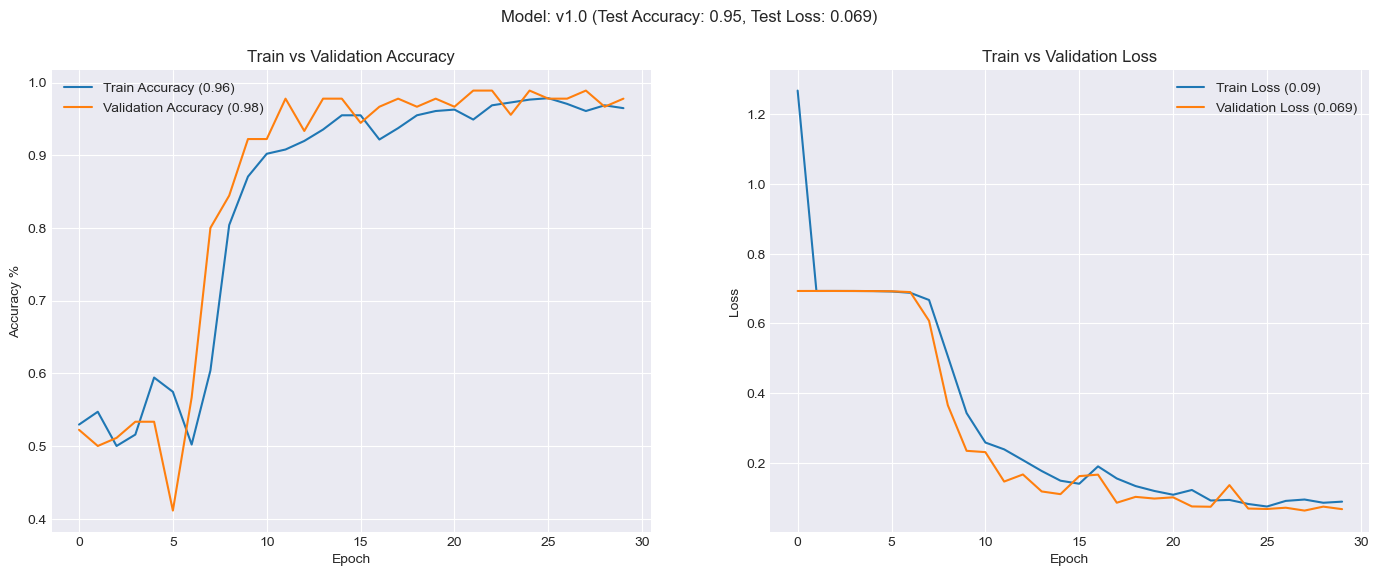

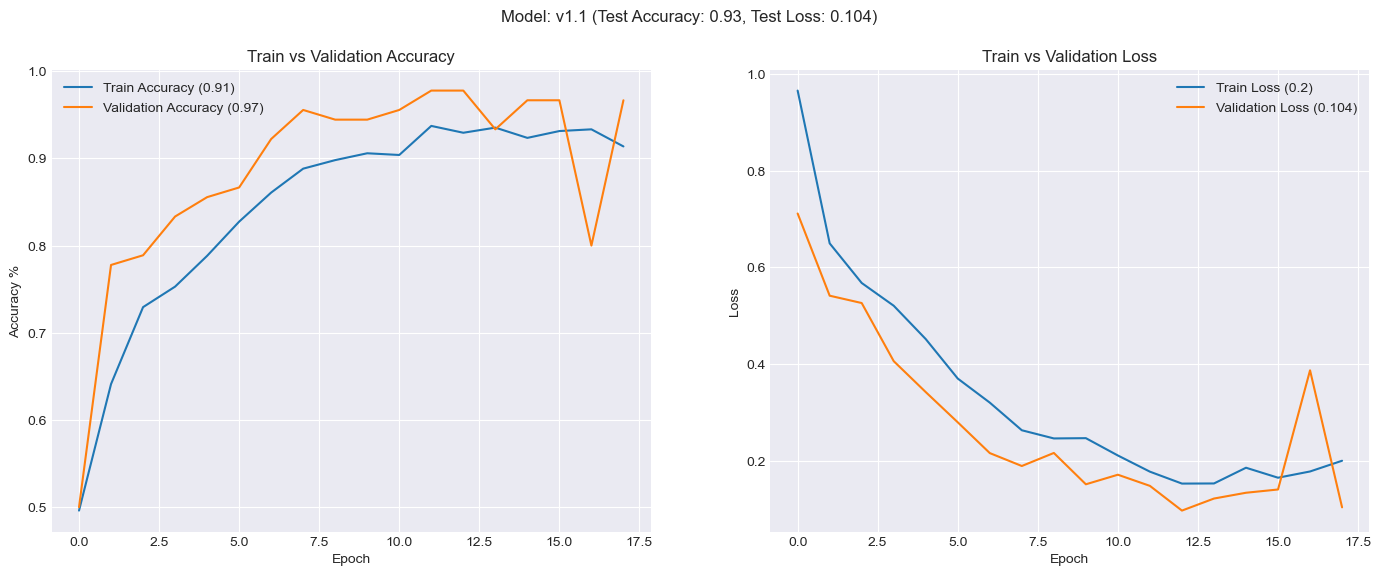

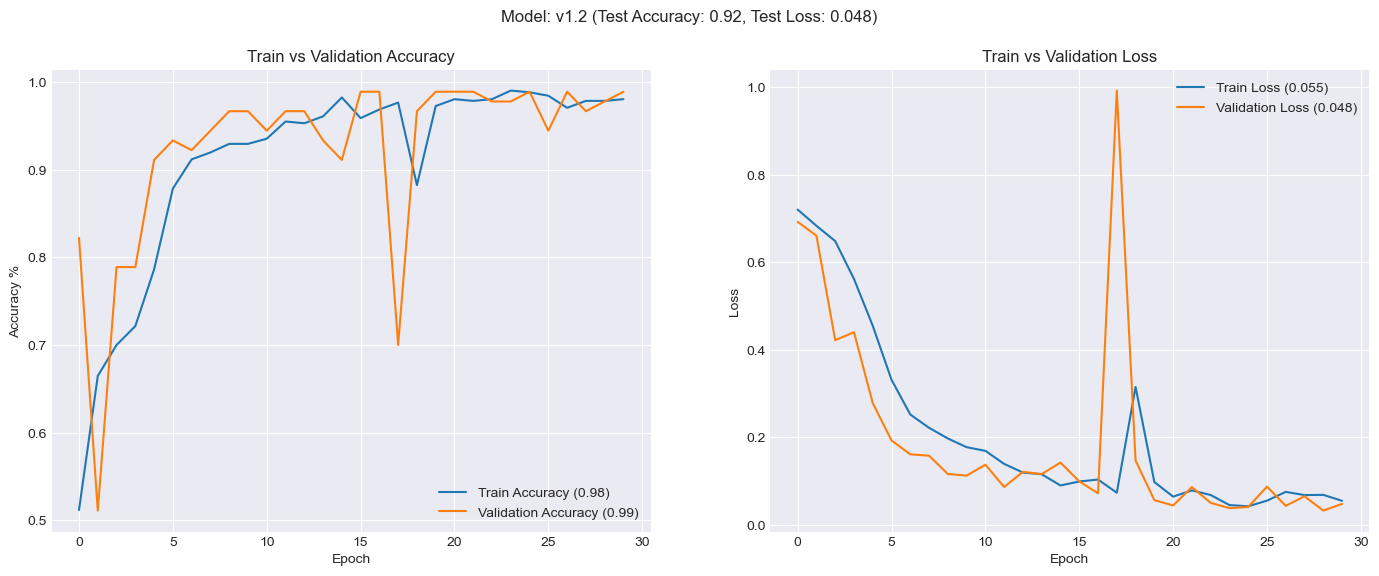

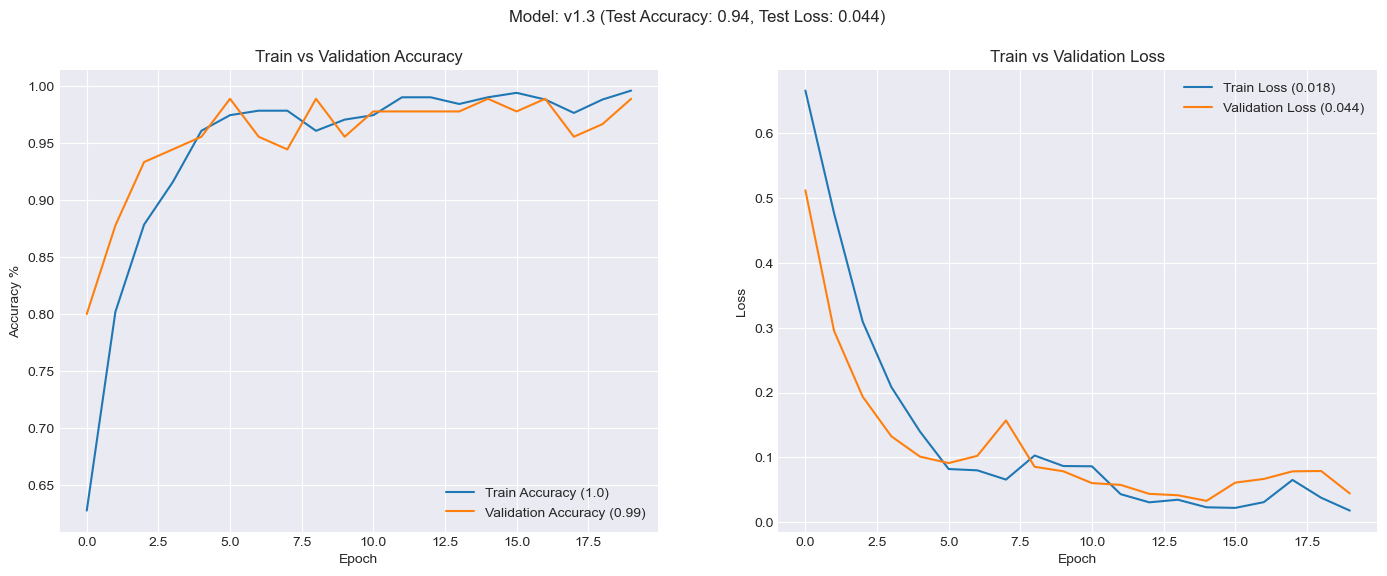

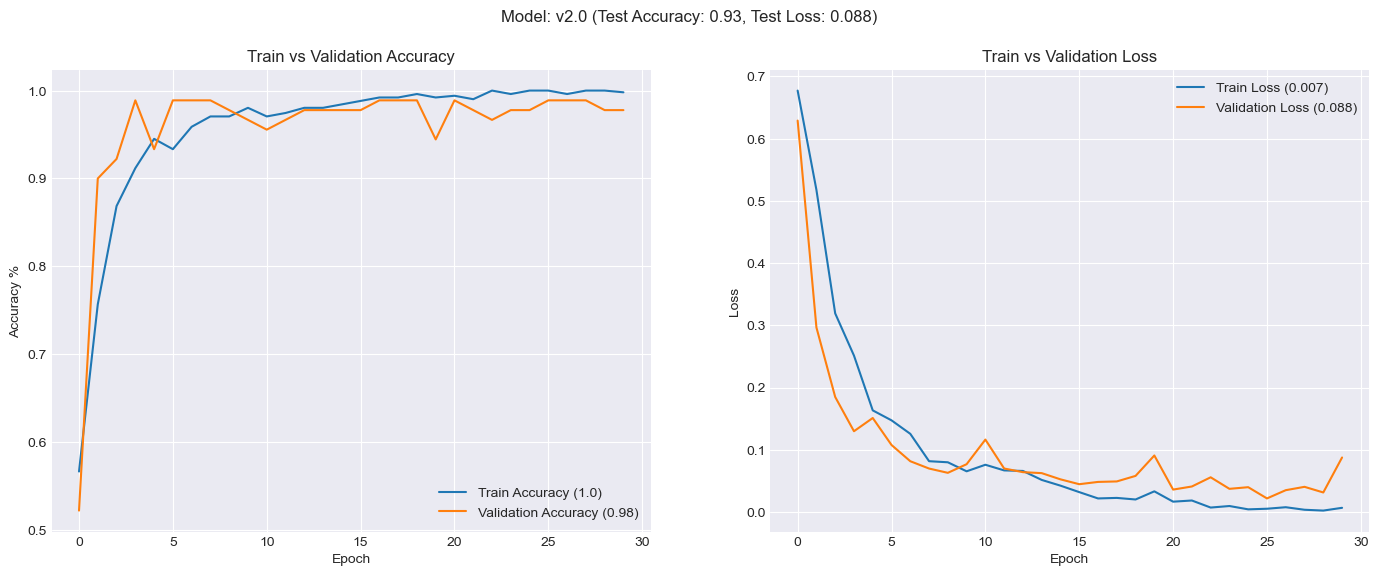

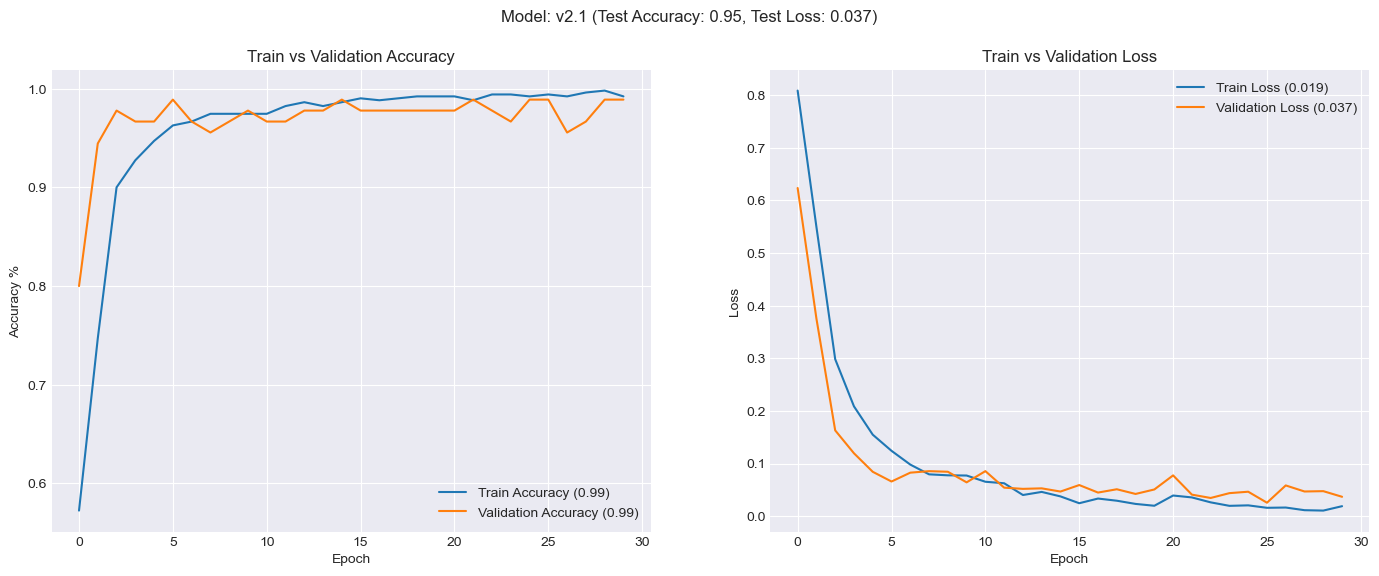

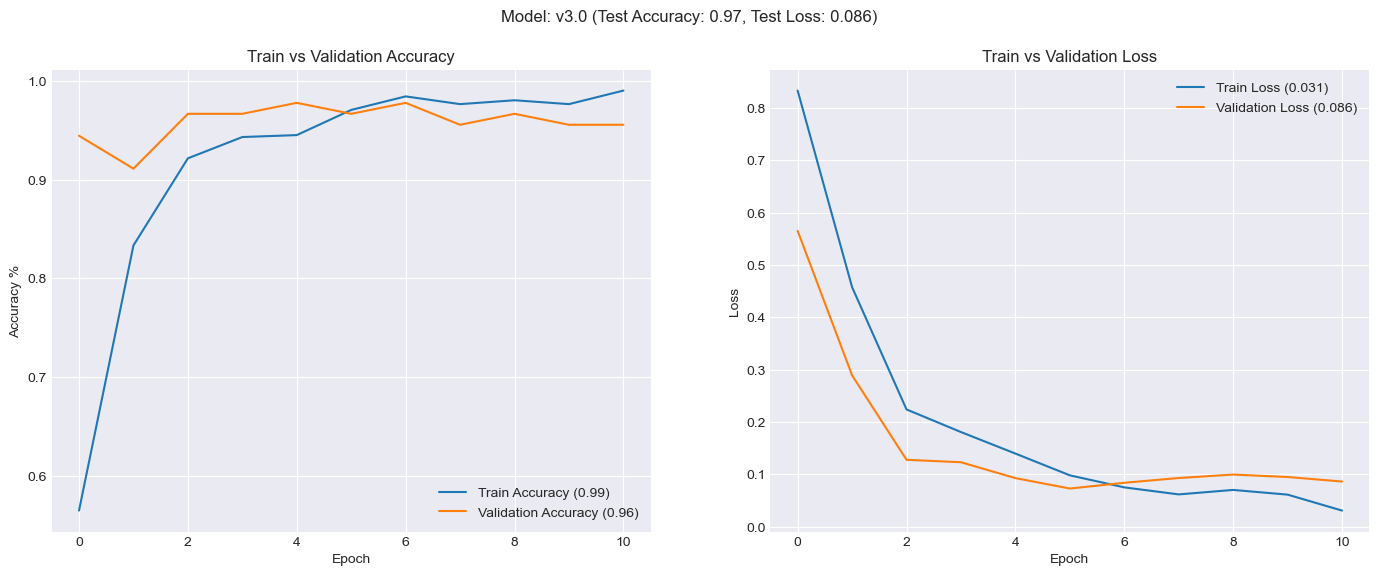

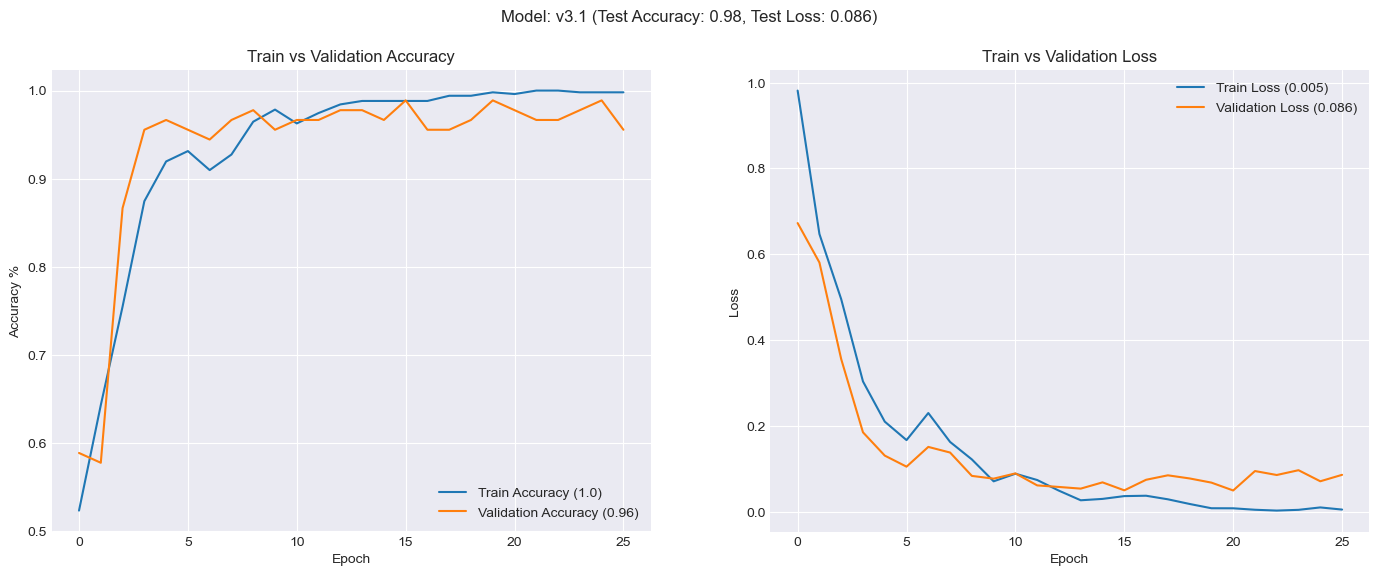

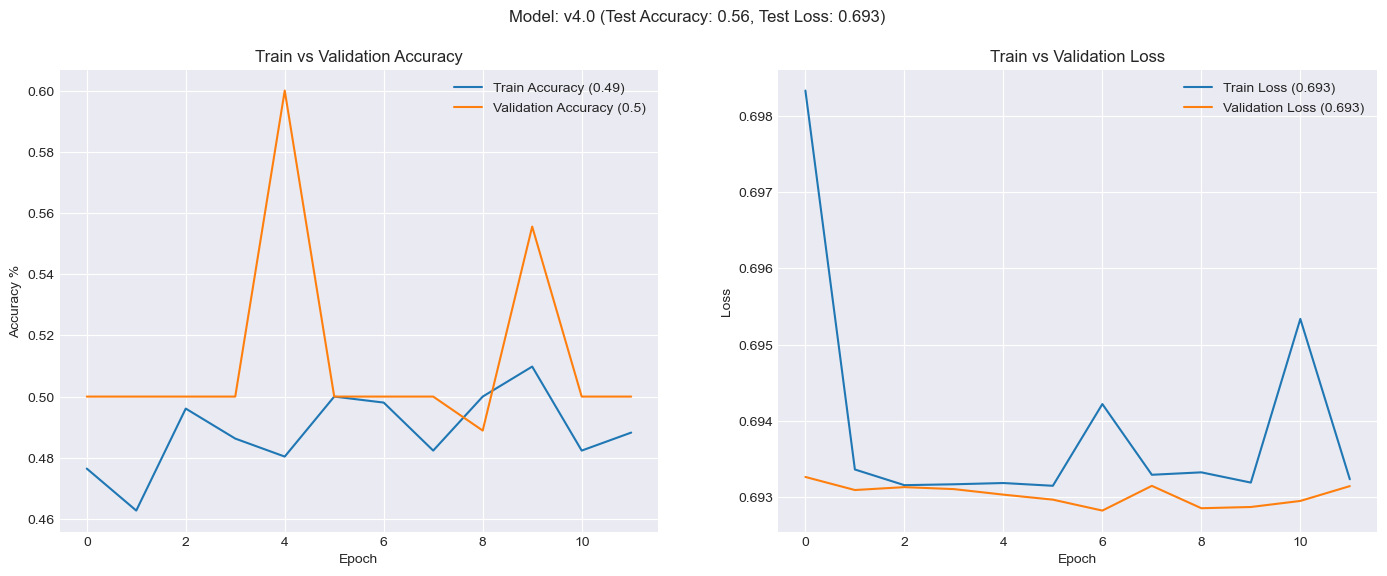

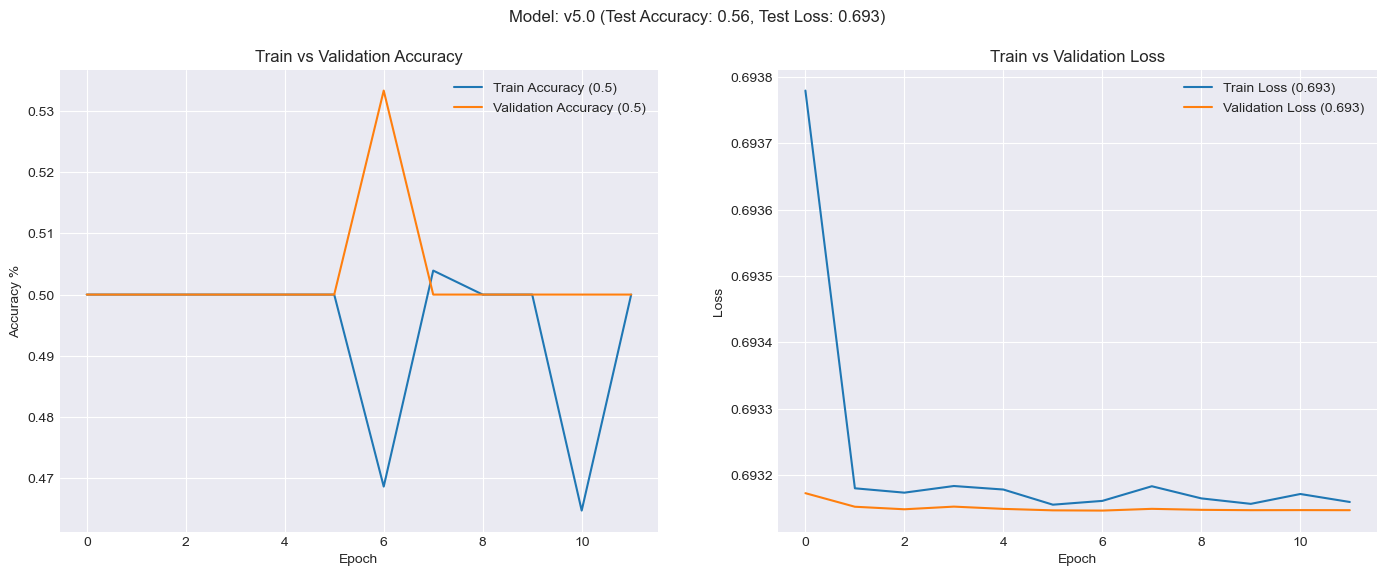

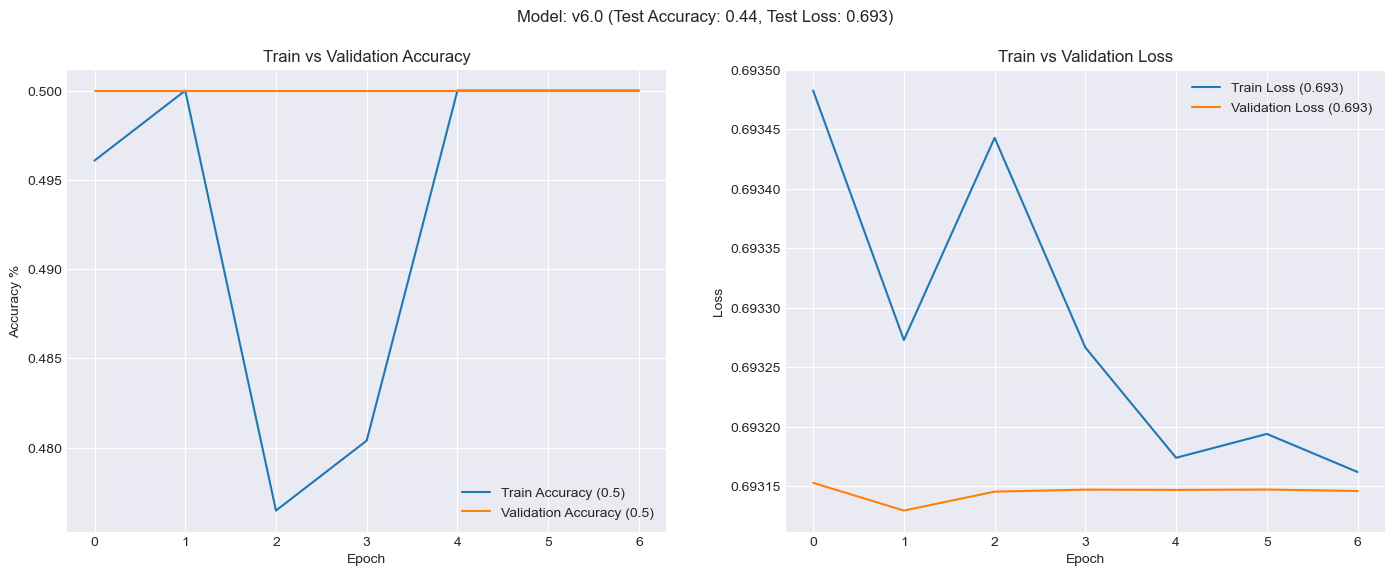

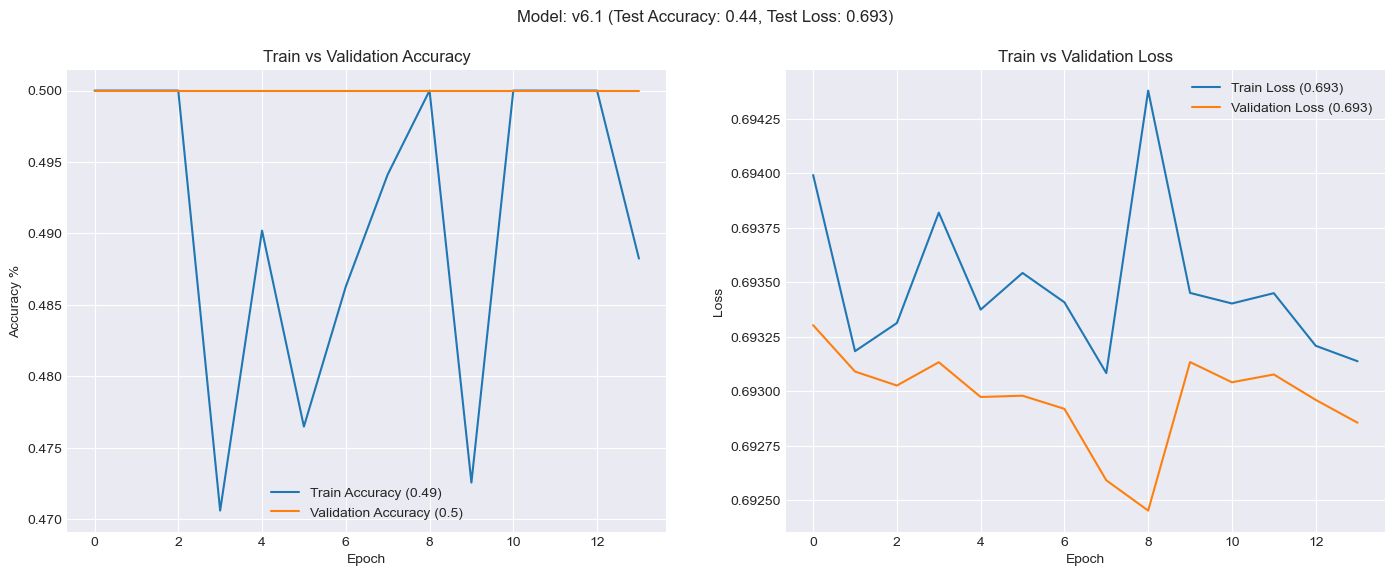

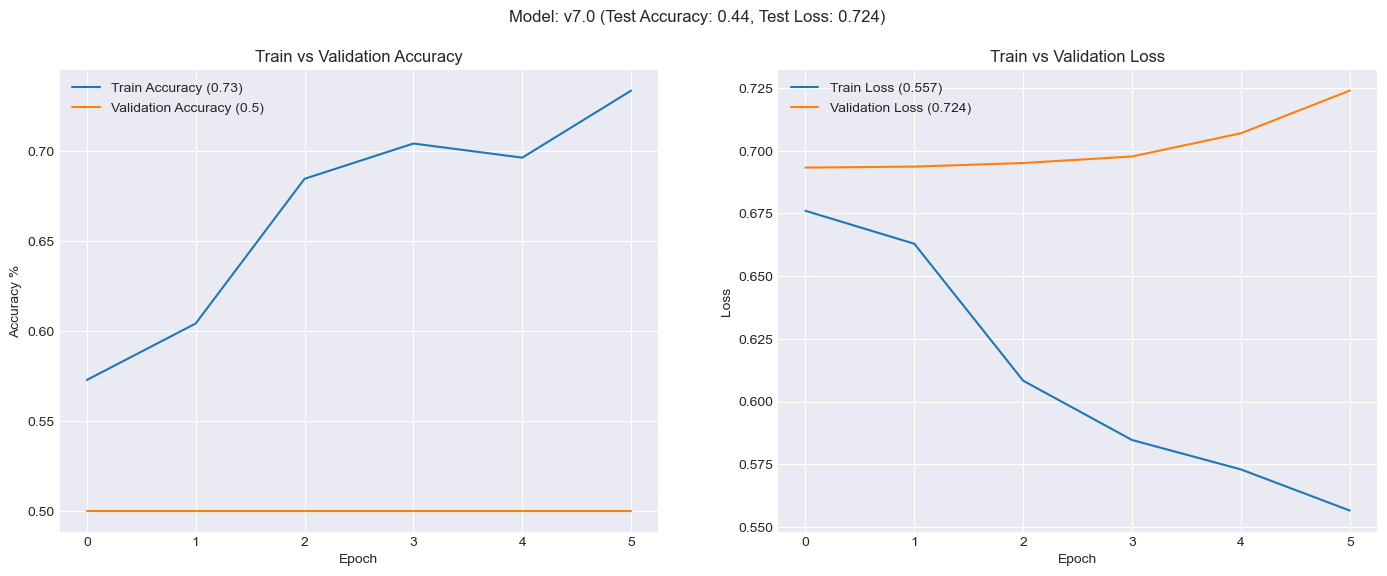

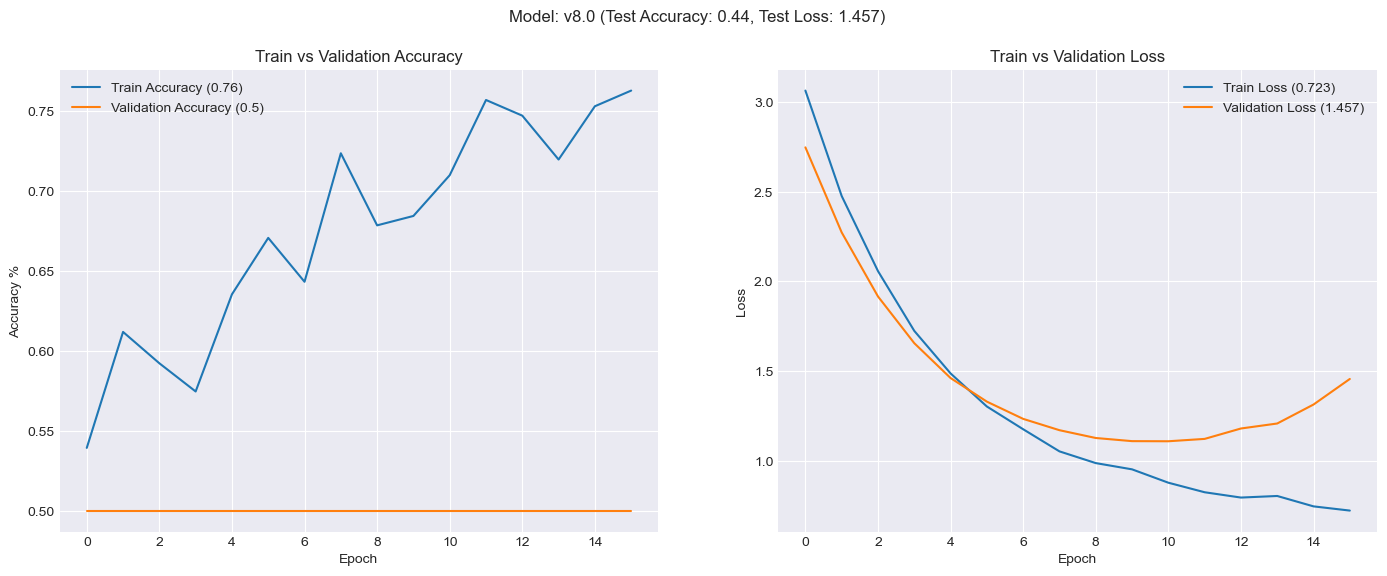

In [109]:
for index in range(len(results_df['Model'])):
    plt.figure(figsize=(17,6))
    plt.subplot(1,2,1)
    plt.plot(history_list[index]['Train accuracy'], label=f'Train Accuracy ({round(history_list[index]["Train accuracy"][-1],2)})')
    plt.plot(history_list[index]['Val accuracy'], label=f'Validation Accuracy ({round(history_list[index]["Val accuracy"][-1],2)})')
    plt.title('Train vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy %')
    plt.legend()

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(history_list[index]['Train loss'], label=f'Train Loss ({round(history_list[index]["Train loss"][-1],3)})')
    plt.plot(history_list[index]['Val loss'], label=f'Validation Loss ({round(history_list[index]["Val loss"][-1], 3)})')
    plt.title('Train vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.suptitle(f'Model: {history_list[index]["Model"]} (Test Accuracy: {round(results_df["Test Acc"][index],2)}, Test Loss: {round(history_list[index]["Val loss"][-1],3)})')
    plt.show()


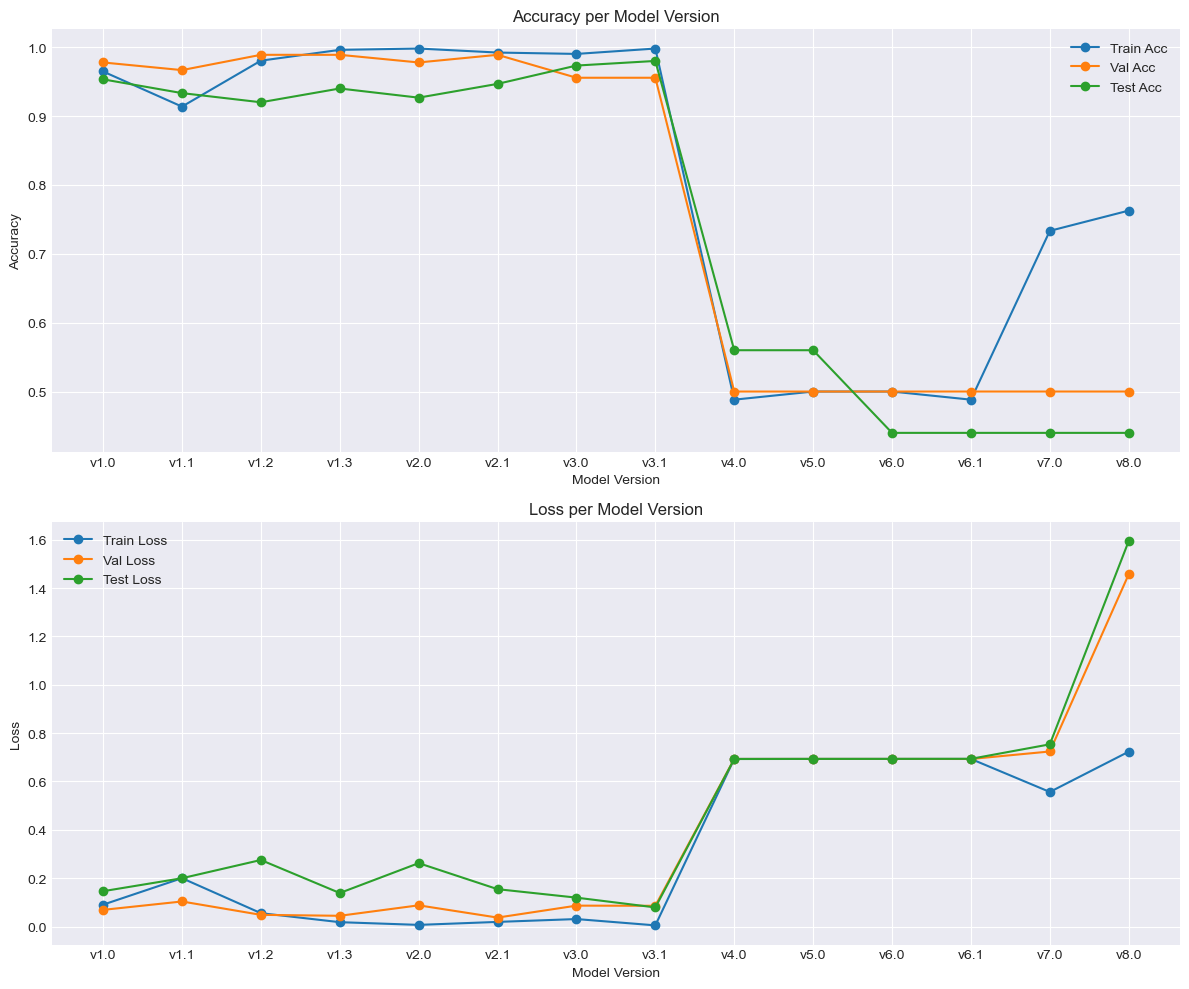

In [134]:
plt.figure(figsize=(12, 10))

# Accuracy
plt.subplot(2, 1, 1)
for metric in ["Train Acc", "Val Acc", "Test Acc"]:
    plt.plot(results_df["Model"], results_df[metric], marker='o', label=metric)
plt.title("Accuracy per Model Version")
plt.xlabel("Model Version")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(2, 1, 2)
for metric in ["Train Loss", "Val Loss", "Test Loss"]:
    plt.plot(results_df["Model"], results_df[metric], marker='o', label=metric)
plt.title("Loss per Model Version")
plt.xlabel("Model Version")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


#### Загальний висновок

- **Оптимальні результати** дають класичні CNN з кількома шарами Conv2D та Flatten (v1.0–v3.1).
- **Мобільні та сильно регуляризовані моделі** на цьому датасеті не працюють — ймовірно, через малий розмір вибірки або невідповідність архітектури.
- **Результат:** Для задачі бінарної класифікації з невеликим датасетом краще використовувати прості, але достатньо глибокі CNN без надмірної регуляризації чи додаткових шарів.